> Try to divide train and test(GNAR fivenet)

- missing 채우기
- ST-GCN
- Furier Transform
- Ebayes( 퓨리에 후 벡터값 큰 것만 남김)
- 역furier
- ST-GCN
- furier
- Ebayes
- 역 furier
- ST-GCN
- ..

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(GNAR)
library(igraph)

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union


R[write to console]: Loading required package: wordcloud

R[write to console]: Loading required package: RColorBrewer



# Data

In [5]:
%%R
summary(fiveNet)

GNARnet with 5 nodes and 10 edges
 of equal length  1

In [6]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [7]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

In [8]:
edges_tensor = torch.tensor(edges)

In [9]:
nonzero_indices = edges_tensor.nonzero()

In [10]:
fiveNet_edge = np.array(nonzero_indices).T

In [11]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [12]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [13]:
fiveVTS.shape

(200, 5)

In [14]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

In [15]:
fiveVTS_train.shape, fiveVTS_test.shape

((160, 5), (40, 5))

# Randomly Missing Values

In [16]:
np.random.seed(1)
seed_number1 = np.random.choice(160,80,replace=False)

In [17]:
np.random.seed(3)
seed_number2 = np.random.choice(160,80,replace=False)

In [18]:
np.random.seed(5)
seed_number3 = np.random.choice(160,80,replace=False)

In [19]:
np.random.seed(7)
seed_number4 = np.random.choice(160,80,replace=False)

In [20]:
np.random.seed(9)
seed_number5 = np.random.choice(160,80,replace=False)

In [21]:
fiveVTS_train[seed_number1,0] = float('nan')

In [22]:
fiveVTS_train[seed_number2,1] = float('nan')

In [23]:
fiveVTS_train[seed_number3,2] = float('nan')

In [24]:
fiveVTS_train[seed_number4,3] = float('nan')

In [25]:
fiveVTS_train[seed_number5,4] = float('nan')

# 1. Missing Value - Mean

In [26]:
fiveVTS_train_mean = fiveVTS_train.copy()

In [27]:
fiveVTS_train_mean[seed_number1,0] = np.nanmean(fiveVTS_train_mean[:,0])

In [28]:
fiveVTS_train_mean[seed_number2,1] = np.nanmean(fiveVTS_train_mean[:,1])

In [29]:
fiveVTS_train_mean[seed_number3,2] = np.nanmean(fiveVTS_train_mean[:,2])

In [30]:
fiveVTS_train_mean[seed_number4,3] = np.nanmean(fiveVTS_train_mean[:,3])

In [31]:
fiveVTS_train_mean[seed_number5,4] = np.nanmean(fiveVTS_train_mean[:,4])

## 1) ST-GCN

In [32]:
mean_f_fiveVTS_train = torch.tensor(fiveVTS_train_mean).reshape(160,5,1).float()

In [33]:
mean_X_fiveVTS = mean_f_fiveVTS_train[:159,:,:]
mean_y_fiveVTS = mean_f_fiveVTS_train[1:,:,:]

In [34]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [44]:
mean_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

## 2) Fourier transform

In [46]:
w=np.zeros((159*N,159*N))

In [47]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [48]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ mean_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 3) Ebayes

In [49]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 4) Inverse Fourier transform

In [50]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 5) ST-GCN

In [51]:
mean_spatio_temporal = torch.tensor(fhatbarhat_mean_spatio_temporal).reshape(159,5,1).float()

In [52]:
mean_X_spatio_temporal = mean_spatio_temporal[:158,:,:]
mean_y_spatio_temporal = mean_spatio_temporal[1:,:,:]

In [53]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio_temporal,mean_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


In [54]:
mean_X_spatio_temporal_fore = mean_spatio_temporal[119:,:,:]

In [55]:
mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_temporal_fore]).detach().numpy()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe72801f1f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe72ebcc340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe72801f100>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe72ebd97f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe72ebd9f70>,
 'means': []}

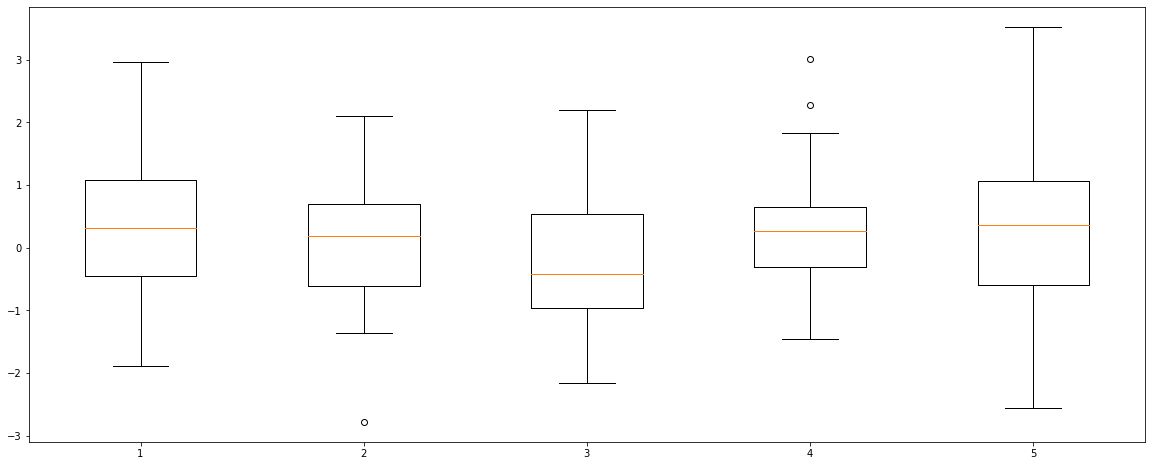

In [56]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe72ec489d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe72ec41550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe72ec48610>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe72ec41ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe72ec3d760>],
 'means': []}

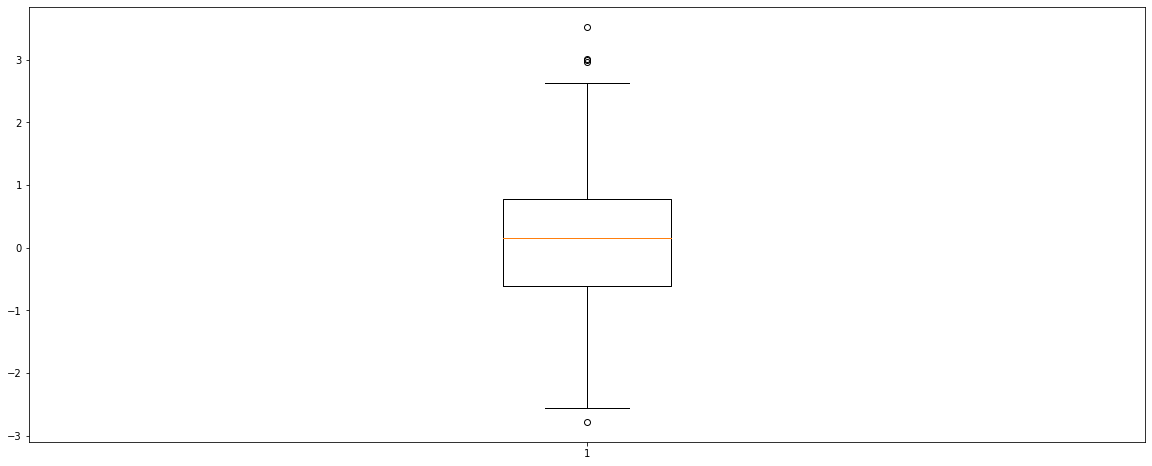

In [57]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 6) Fourier transform

In [58]:
mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_spatio_temporal]).detach().numpy()

In [59]:
w=np.zeros((159*N,159*N))

In [60]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [61]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ mean_fhat_spatio_temporal.reshape(159*N,1)
power = fhatbar**2 

## 7) Ebayes

In [62]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 8) Inverse Fourier transform

In [63]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 9) ST-GCN

In [64]:
mean_spatio_temporal2 = torch.tensor(fhatbarhat_mean_spatio_temporal).reshape(159,5,1).float()

In [65]:
mean_X_spatio_temporal2 = mean_spatio_temporal2[:158,:,:]
mean_y_spatio_temporal2 = mean_spatio_temporal2[1:,:,:]

In [66]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio_temporal,mean_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


In [67]:
mean_X_spatio_temporal_fore2 = mean_spatio_temporal2[119:,:,:]

In [68]:
mean_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_temporal_fore2]).detach().numpy()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe72062b820>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe72062bdc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe72062b550>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe7206383d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7206386a0>,
 'means': []}

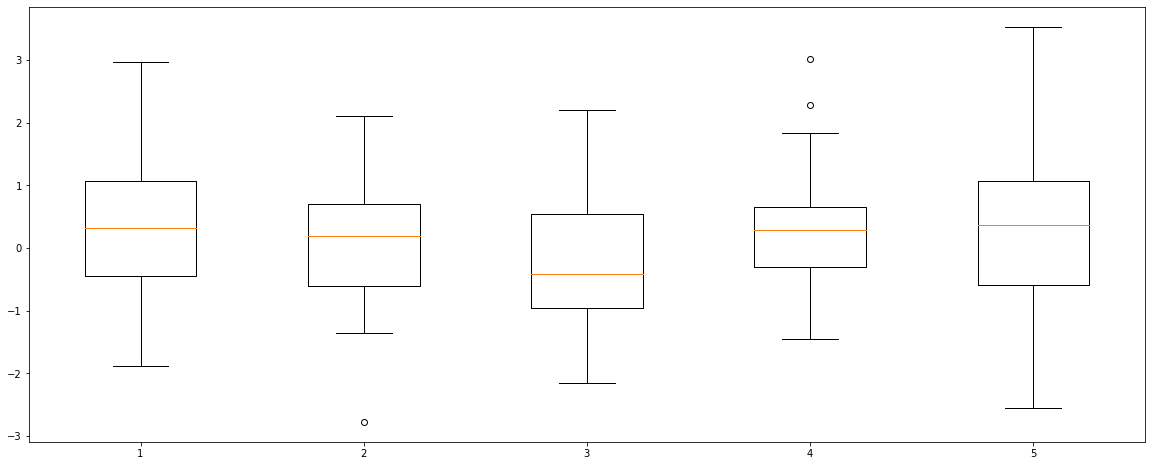

In [69]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe72056d220>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe72056d7c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe72055ef10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe72056dd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe72057a0a0>],
 'means': []}

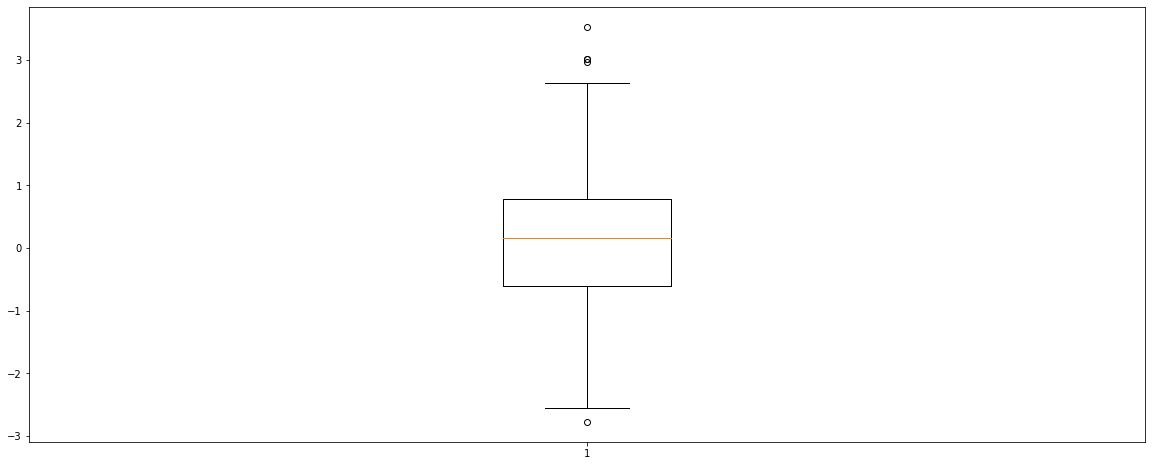

In [70]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

# 2. Missing Value - Linear Interpolation

In [71]:
_df = pd.DataFrame(fiveVTS_train)
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [72]:
linear_fiveVTS_train = np.array(_df).reshape(160,5)

## 1) ST-GCN

In [73]:
linear_f_fiveVTS_train = torch.tensor(linear_fiveVTS_train).reshape(160,5,1).float()

In [74]:
linear_X_fiveVTS = linear_f_fiveVTS_train[:159,:,:]
linear_y_fiveVTS = linear_f_fiveVTS_train[1:,:,:]

In [75]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_fiveVTS,linear_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


In [80]:
linear_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_fiveVTS]).detach().numpy()

## 2) Fourier transform

In [76]:
w=np.zeros((159*N,159*N))

In [77]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [81]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 3) Ebayes

In [82]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 4) Inverse Fourier transform

In [83]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 5) ST-GCN

In [84]:
linear_spatio_temporal = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [85]:
linear_X_spatio_temporal = linear_spatio_temporal[:158,:,:]
linear_y_spatio_temporal = linear_spatio_temporal[1:,:,:]

In [86]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal,linear_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


---

In [87]:
linear_X_spatio_temporal_fore = linear_spatio_temporal[119:,:,:]

In [88]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal_fore]).detach().numpy()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe7204fae20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe7204fc970>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe7204fa070>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe7204fc220>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7204fcfd0>,
 'means': []}

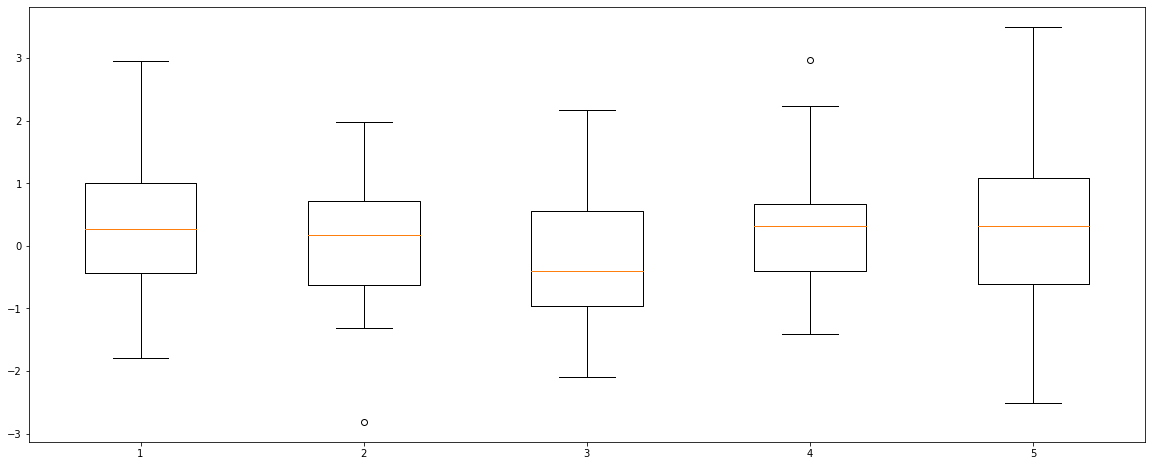

In [89]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe7203f2070>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe7203f2640>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe7203e4d60>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe7203f2be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7203f2eb0>],
 'means': []}

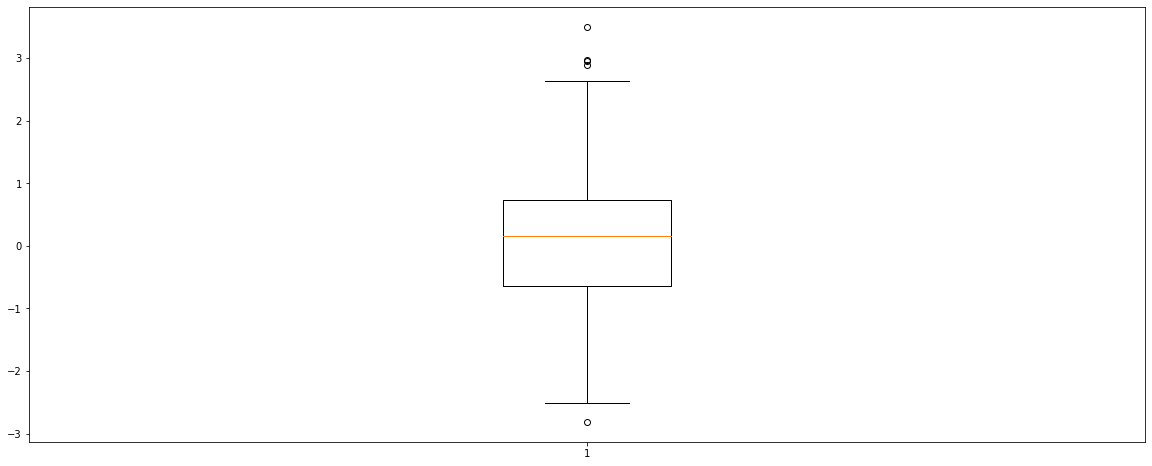

In [90]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 6) Fourier transform

In [91]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_spatio_temporal]).detach().numpy()

In [92]:
w=np.zeros((159*N,159*N))

In [93]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [94]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 7) Ebayes

In [95]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 8) Inverse Fourier transform

In [96]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 9) ST-GCN

In [97]:
linear_spatio_temporal2 = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [98]:
linear_X_spatio_temporal2 = linear_spatio_temporal2[:158,:,:]
linear_y_spatio_temporal2 = linear_spatio_temporal2[1:,:,:]

In [99]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal2,linear_y_spatio_temporal2)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


In [100]:
linear_X_spatio_temporal_fore2 = linear_spatio_temporal2[119:,:,:]

In [103]:
linear_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal_fore2]).detach().numpy()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe720379a60>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe720379ee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe720379790>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe7202a64c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7202a6790>,
 'means': []}

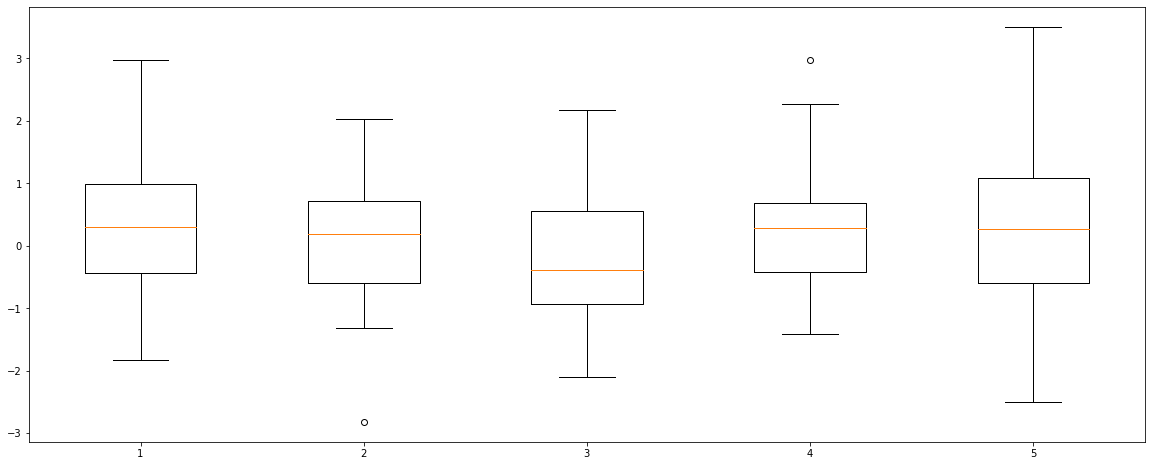

In [104]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe720254550>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe720254af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe7202543a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe7201e0100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7201e03d0>],
 'means': []}

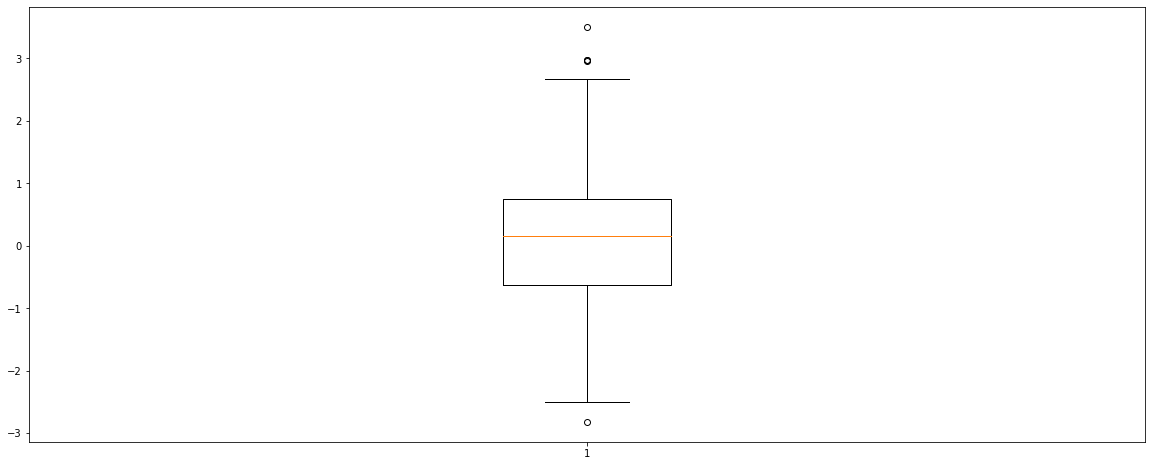

In [105]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## GNAR

**mean**

In [106]:
%R -i fiveVTS_train_mean

In [107]:
%%R
meanprediction <- predict(GNARfit(vts = fiveVTS_train_mean[1:160,], net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1)),n.ahead=40)

In [108]:
%R -o meanprediction

In [109]:
sum((meanprediction.reshape(40,5)[1] -  fiveVTS_test[1])**2)

3.8828590908470577

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe7201b9670>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe7201b9c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe7201b93a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe7201c81f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7201c84c0>,
 'means': []}

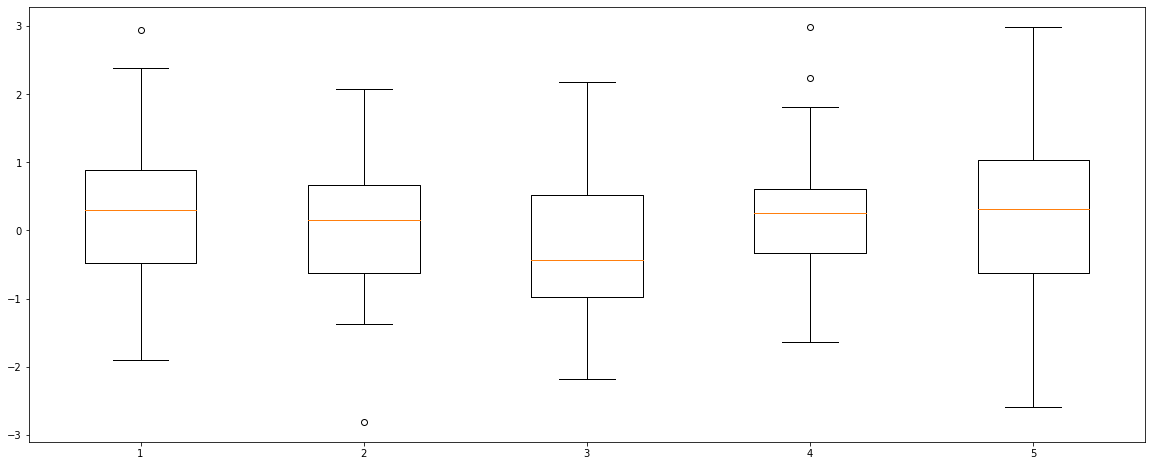

In [110]:
plt.figure(figsize=(20, 8))
plt.boxplot((meanprediction.reshape(40,5) -  fiveVTS_test))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe7200eebb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe7200fc190>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe72015d700>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe7200fc730>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe7200fca00>],
 'means': []}

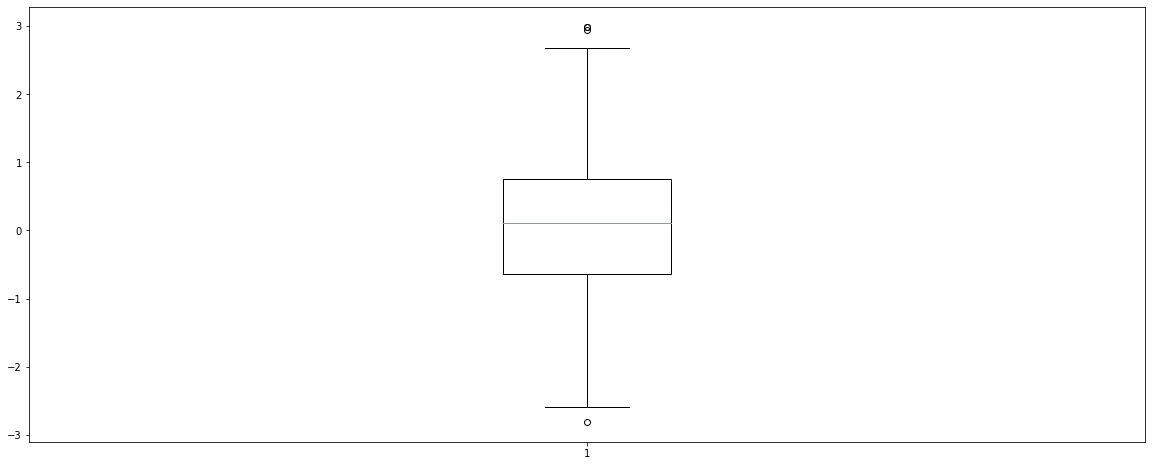

In [111]:
plt.figure(figsize=(20, 8))
plt.boxplot(((meanprediction.reshape(40,5) -  fiveVTS_test)).reshape(200,1))